In [1]:
# Imports
from Main.framework import Value
from Main.neuralnet import Neuron, Layer, MLP
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
np.random.seed(42)
random.seed(42)

In [2]:
# Generate a dataset
rX, rY = make_moons(n_samples=1000, noise=0.3)

In [3]:
rX

array([[-0.17186341,  0.59624885],
       [ 1.25328273, -0.26541353],
       [ 0.72322405,  0.2319425 ],
       ...,
       [ 1.77095705, -0.50943619],
       [-1.06177158,  0.006786  ],
       [ 0.76117231,  0.65196041]])

In [4]:
rY

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,

In [5]:
rY = np.array([2*i-1 for i in rY])  # Convert y to be -1 or 1

In [6]:
# Train - Test split
X,Xtest,y,ytest=train_test_split(rX,rY,test_size=0.2,random_state=42)

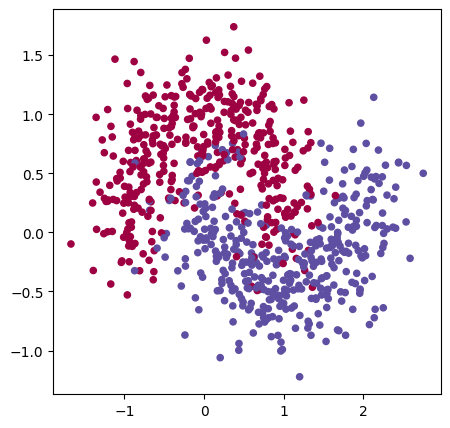

In [7]:
# Visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='Spectral')
plt.show()

In [8]:
# Initialize a model
model = MLP(2, [16,16, 1])  # 2-layer mlp
print("Number of parameters:", len(model.parameters()))

Number of parameters: 337


In [9]:
# loss function
def loss(batch_size=None):
    # Inline DataLoader
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # Forward the model to get scores
    scores = list(map(model, inputs))

    # SVM "max-margin" loss
    losses = [(1 + -yi * scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p * p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # Calculate accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)


In [10]:
# Calculate initial loss and accuracy
total_loss, acc = loss()
print(f"Initial loss: {total_loss.data:.4f}, accuracy: {acc * 100:.2f}%")

Initial loss: 0.7191, accuracy: 72.25%


In [11]:
# Initialize DataFrame to store optimization details
optimization_details = pd.DataFrame(columns=['Loss', 'Accuracy'])

# Optimization loop
for k in range(120):
    # Forward
    total_loss, acc = loss(30) # Adjust batch size based on sample and memory constraints

    # Backward
    model.zero_grad()
    total_loss.backward()

    # Update (SGD)
    learning_rate = 1.0 - 0.9 * k / 100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    # Store details in DataFrame
    optimization_details.loc[len(optimization_details.index)] = { 'Loss': total_loss.data, 'Accuracy': acc}
    
optimization_details.index += 1

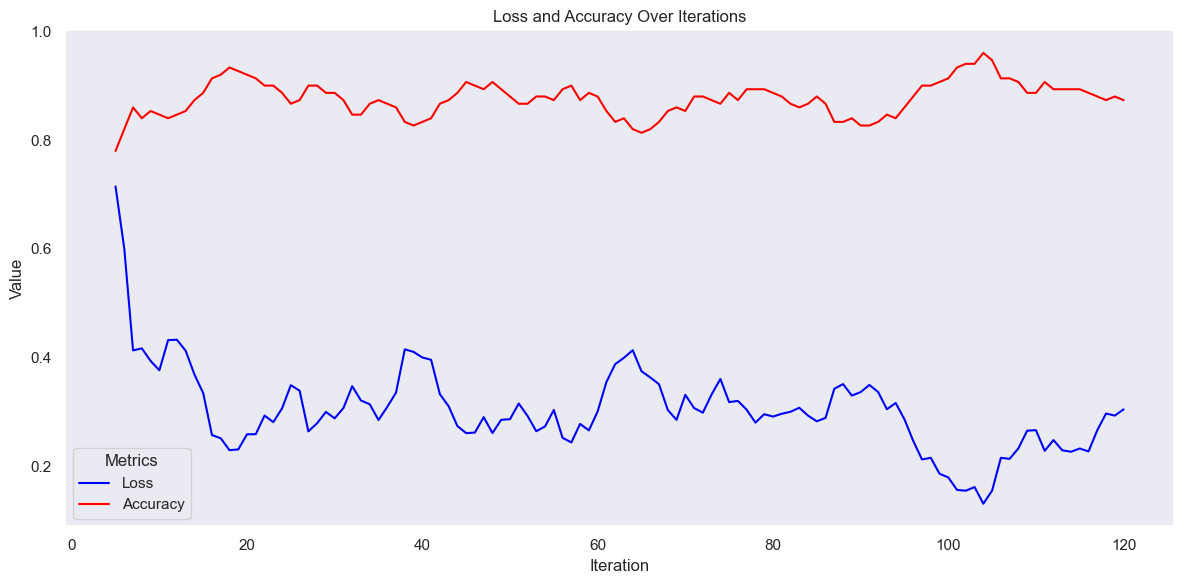

In [12]:
# Visualize Training process
def viz_training(details):
    
    # Smooth the curves using a rolling mean
    details['Loss_Smooth'] = details['Loss'].rolling(window=5).mean()
    details['Accuracy_Smooth'] = details['Accuracy'].rolling(window=5).mean()

    # Visualization
    plt.figure(figsize=(12, 6))

    # Set the style
    sns.set(style="dark", palette="Spectral")

    # Create line plots for Loss and Accuracy
    sns.lineplot(data=details, x=details.index, y='Loss_Smooth', color='b', label='Loss')
    sns.lineplot(data=details, x=details.index, y='Accuracy_Smooth', color='r', label='Accuracy')

    plt.title('Loss and Accuracy Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.legend(title='Metrics')

    plt.tight_layout()
    plt.show()

viz_training(optimization_details)


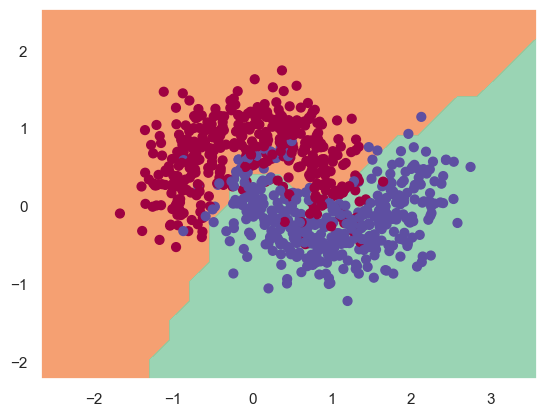

In [13]:
# Visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, cmap='Spectral', alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

In [14]:
# Predictions on Test and Train data
y_pred_test = [1 if model([Value(xi[0]), Value(xi[1])]).data > 0 else -1 for xi in Xtest]
y_pred_train = [1 if model([Value(xi[0]), Value(xi[1])]).data > 0 else -1 for xi in X]

In [15]:
def plot_metrics(y_train, y_pred_train, y_test, y_pred_test):
    # Calculate metrics for training data
    precision_train = precision_score(y_train, y_pred_train) * 100
    recall_train = recall_score(y_train, y_pred_train) * 100
    f1_train = f1_score(y_train, y_pred_train)
    
    # Calculate metrics for test data
    precision_test = precision_score(y_test, y_pred_test) * 100
    recall_test = recall_score(y_test, y_pred_test) * 100
    f1_test = f1_score(y_test, y_pred_test)
    
    # Create a DataFrame to store the metrics
    metrics = {
        'KPI': ['Precision', 'Recall', 'F1 Score'],
        'Training Data': [precision_train, recall_train, f1_train],
        'Test Data': [precision_test, recall_test, f1_test]
    }
    
    metrics_df = pd.DataFrame(metrics).set_index('KPI')
    
    return metrics_df

metrics_df = plot_metrics(y, y_pred_train, ytest, y_pred_test)
metrics_df

,Training Data,Test Data
KPI,,
Precision,88.019560,87.128713
Recall,90.000000,88.000000
F1 Score,0.889988,0.875622


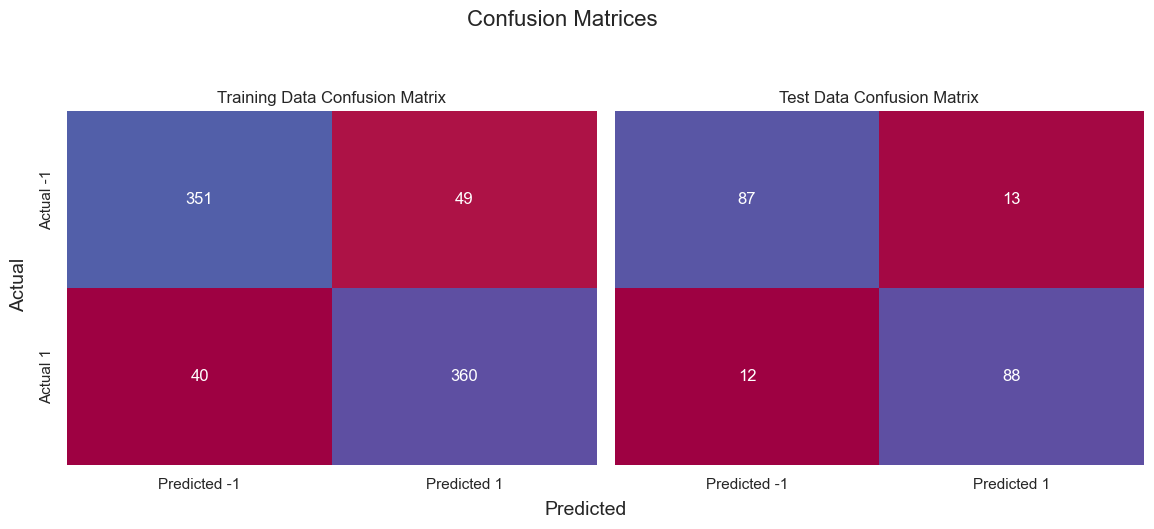

In [16]:
def plot_matrix(y_true, y_pred, title, ax, fontsize=12):
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Spectral', cbar=False,
                xticklabels=['Predicted -1', 'Predicted 1'], yticklabels=['Actual -1', 'Actual 1'], 
                ax=ax, annot_kws={"size": fontsize})
    ax.set_title(f'{title} Confusion Matrix', fontsize=fontsize)

# Plot confusion matrices side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

plot_matrix(y, y_pred_train, "Training Data", axs[0])
plot_matrix(ytest, y_pred_test, "Test Data", axs[1])

# Set shared axis labels
fig.text(0.52, 0.04, 'Predicted', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Actual', va='center', rotation='vertical', fontsize=14)

# Set the overall title for the plot
fig.suptitle('Confusion Matrices', fontsize=16, y=1.05)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()
